In [72]:
import os

# 데이터 경로 설정
train_dir = 'train'
test_dir = 'test'
labels_file = 'labels.csv'

# 파일 확인
print(f"훈련 이미지 경로: {train_dir}")
print(f"테스트 이미지 경로: {test_dir}")
print(f"레이블 파일 경로: {labels_file}")

print("\n훈련 이미지 디렉토리 파일 예시:")
print(os.listdir(train_dir)[:5])  # 훈련 이미지 파일 목록 일부 출력

print("\n테스트 이미지 디렉토리 파일 예시:")
print(os.listdir(test_dir)[:5])  # 테스트 이미지 파일 목록 일부 출력

# 레이블 파일 확인
print("\n레이블 파일 내용 예시:")
with open(labels_file, 'r') as file:
    for i, line in enumerate(file):
        print(line.strip())
        if i >= 5:  # 처음 5줄만 출력
            break


훈련 이미지 경로: train
테스트 이미지 경로: test
레이블 파일 경로: labels.csv

훈련 이미지 디렉토리 파일 예시:
['53f89cf0e6bc883462dc5a147462fe37.jpg', '58ca1366de1592e48fefa05d4c833942.jpg', '94e9f738b011bc5258d0593fbd9d4bb6.jpg', '9bef849130e5759f4e77d9cdbd72034a.jpg', 'a6c40bfb565f1f99d400ed89f332db75.jpg']

테스트 이미지 디렉토리 파일 예시:
['1dbb9c899296b634dab9a43601a66a92.jpg', '6ae4fdf29e4e33b011856409dfc1b0a5.jpg', '53789615849b9f618c279670c859f61c.jpg', '12595290a6be01f4edc990edd1e69a64.jpg', '369b66c149b857c369f839c1a2840e74.jpg']

레이블 파일 내용 예시:
id,breed
000bec180eb18c7604dcecc8fe0dba07,boston_bull
001513dfcb2ffafc82cccf4d8bbaba97,dingo
001cdf01b096e06d78e9e5112d419397,pekinese
00214f311d5d2247d5dfe4fe24b2303d,bluetick
0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [73]:
import pandas as pd

# 레이블 데이터 로드
labels_df = pd.read_csv(labels_file)

# 데이터프레임의 첫 몇 줄을 출력
print("\n레이블 데이터프레임 상위 5개 행:")
print(labels_df.head())

# 데이터프레임의 기본 정보 확인
print("\n레이블 데이터프레임 정보:")
print(labels_df.info())

# 레이블 분포 확인
print("\n레이블 분포:")
print(labels_df['breed'].value_counts())



레이블 데이터프레임 상위 5개 행:
                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever

레이블 데이터프레임 정보:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10222 entries, 0 to 10221
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      10222 non-null  object
 1   breed   10222 non-null  object
dtypes: object(2)
memory usage: 159.8+ KB
None

레이블 분포:
breed
scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
                       ... 
golden_retriever         67
brabancon_griffon        67
komondor                 67
eskimo_dog               66
briard                   66
Name: count, Leng


샘플 이미지 크기: (500, 375)


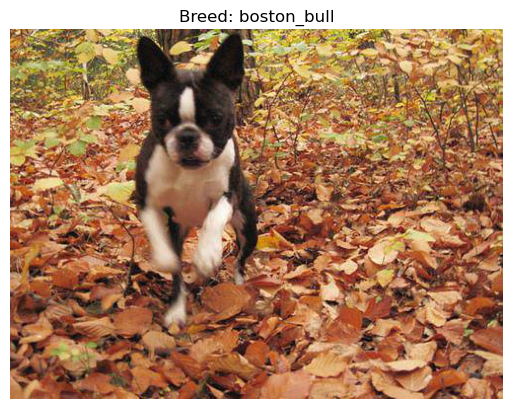

In [74]:
from PIL import Image
import matplotlib.pyplot as plt

# 예시로 첫 번째 이미지 파일 시각화
sample_image_name = os.path.join(train_dir, labels_df.iloc[0, 0] + '.jpg')

# 이미지 열기
image = Image.open(sample_image_name)
print(f"\n샘플 이미지 크기: {image.size}")

# 이미지 시각화
plt.imshow(image)
plt.title(f"Breed: {labels_df.iloc[0, 1]}")
plt.axis('off')
plt.show()


In [90]:
from torchvision import transforms

# 데이터 전처리 설정
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # 이미지를 224x224 크기로 조정
    transforms.ToTensor(),          # 이미지를 텐서로 변환
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # 이미지를 정규화 (ImageNet 기준 평균 및 표준편차)
])


In [106]:
# 레이블 매핑 생성
breed_to_idx = {breed: idx for idx, breed in enumerate(labels_df['breed'].unique())}
idx_to_breed = {idx: breed for breed, idx in breed_to_idx.items()}

class DogBreedDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None, is_test=False):
        self.dataframe = dataframe
        self.img_dir = img_dir
        self.transform = transform
        self.is_test = is_test  # 테스트 데이터셋 여부

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.dataframe.iloc[idx, 0] + '.jpg')  # 이미지 파일 경로 생성
        image = Image.open(img_name)  # 이미지 열기
        
        if not self.is_test:  # 학습/검증 데이터셋인 경우 레이블 처리
            breed_name = self.dataframe.iloc[idx, 1]  # 레이블 가져오기
            label = breed_to_idx[breed_name]  # 문자열 레이블을 숫자로 변환
        else:  # 테스트 데이터셋인 경우 레이블 없음
            label = -1  # 테스트 데이터셋의 경우 사용되지 않음
        
        if self.transform:
            image = self.transform(image)  # 전처리 적용
        
        return image, label


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


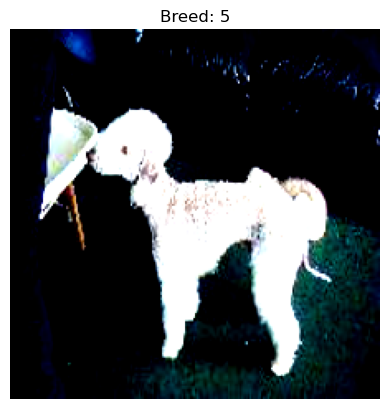

In [92]:
from torch.utils.data import DataLoader

# 훈련 데이터셋 및 데이터로더 생성
train_dataset = DogBreedDataset(dataframe=labels_df, img_dir=train_dir, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)  # 배치 크기 32, 데이터 셔플링

# 비정규화 함수 정의
def imshow(img, title=None):
    img = img / 2 + 0.5  # 비정규화
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if title is not None:
        plt.title(title)
    plt.axis('off')
    plt.show()

# 데이터 로드 및 시각화 테스트
dataiter = iter(train_loader)
images, labels = next(dataiter)

# 첫 번째 이미지 시각화
imshow(images[0], title=f"Breed: {labels[0]}")


균형 잡힌 데이터셋 크기: (7920, 2)
균형 잡힌 데이터셋의 클래스 분포:
breed
boston_bull                  66
dingo                        66
gordon_setter                66
english_foxhound             66
staffordshire_bullterrier    66
                             ..
norwegian_elkhound           66
tibetan_terrier              66
border_terrier               66
toy_poodle                   66
rottweiler                   66
Name: count, Length: 120, dtype: int64


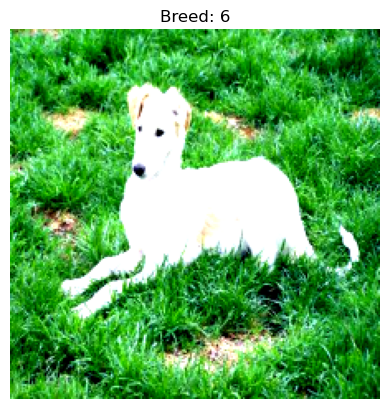

In [93]:
from sklearn.utils import resample

# 각 클래스의 최소 이미지 수 계산
min_class_count = labels_df['breed'].value_counts().min()

# 균형 잡힌 데이터셋 생성
balanced_df = pd.DataFrame()

random_seed= 42

# 각 클래스에서 min_class_count만큼 샘플링
for breed in labels_df['breed'].unique():
    breed_subset = labels_df[labels_df['breed'] == breed]
    balanced_breed_subset = resample(breed_subset, 
                                     replace=False, 
                                     n_samples=min_class_count, 
                                     random_state=42)
    balanced_df = pd.concat([balanced_df, balanced_breed_subset])

print("균형 잡힌 데이터셋 크기:", balanced_df.shape)
print("균형 잡힌 데이터셋의 클래스 분포:")
print(balanced_df['breed'].value_counts())

# 균형 잡힌 훈련 데이터셋 및 데이터로더 생성
balanced_train_dataset = DogBreedDataset(dataframe=balanced_df, img_dir=train_dir, transform=transform)
balanced_train_loader = DataLoader(balanced_train_dataset, batch_size=32, shuffle=True)

import torch

# 비정규화 및 클리핑 함수 정의
def imshow(img, title=None):
    img = img / 2 + 0.5  # 비정규화: Normalize에서 사용된 mean과 std의 반대 연산 수행
    img = torch.clamp(img, 0, 1)  # 이미지 데이터를 [0, 1]로 클리핑
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if title is not None:
        plt.title(title)
    plt.axis('off')
    plt.show()

# 데이터 로드 및 시각화 테스트
dataiter = iter(balanced_train_loader)
images, labels = next(dataiter)

# 첫 번째 이미지 시각화
imshow(images[0].cpu(), title=f"Breed: {labels[0]}")



In [94]:
import torch
import torch.nn as nn
import torchvision.models as models

# 사전 훈련된 ResNet 모델 로드
model = models.resnet50(pretrained=True)

# 출력층 수정: 120개의 강아지 품종 클래스에 맞게 출력층 조정
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 120)

# 모델을 GPU로 이동
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

print(model)


/home/sdf1ai810/miniconda3/envs/module01/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sdf1ai810/miniconda3/envs/module01/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [95]:
import torch.optim as optim

# 손실 함수와 옵티마이저 정의
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [96]:
num_epochs = 10

for epoch in range(num_epochs):
    model.train()  # 모델을 학습 모드로 설정
    running_loss = 0.0
    
    for inputs, labels in balanced_train_loader:
        inputs, labels = inputs.to(device), labels.to(device, dtype=torch.long)  # 여기서 labels를 정수형으로 변환
        
        # 옵티마이저 초기화
        optimizer.zero_grad()
        
        # Forward 패스
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward 패스 및 옵티마이저 스텝
        loss.backward()
        optimizer.step()
        
        # 손실 값 갱신
        running_loss += loss.item() * inputs.size(0)
    
    epoch_loss = running_loss / len(balanced_train_loader.dataset)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')

print("모델 학습 완료!")


Epoch 1/10, Loss: 4.8031
Epoch 2/10, Loss: 4.5630
Epoch 3/10, Loss: 4.4273
Epoch 4/10, Loss: 4.2341
Epoch 5/10, Loss: 4.0135
Epoch 6/10, Loss: 3.8395
Epoch 7/10, Loss: 3.6923
Epoch 8/10, Loss: 3.4779
Epoch 9/10, Loss: 3.2715
Epoch 10/10, Loss: 3.0984
모델 학습 완료!


In [97]:
from sklearn.metrics import accuracy_score, log_loss
import numpy as np

# 모델 평가 모드로 전환
model.eval()

# 검증 데이터셋 준비 (현재는 학습 데이터의 일부를 사용)
val_loader = balanced_train_loader  # 실제로는 별도의 검증 데이터를 사용하는 것이 좋습니다.

all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device, dtype=torch.long)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# 평가 지표 계산
accuracy = accuracy_score(all_labels, all_preds)
print(f'Validation Accuracy: {accuracy:.4f}')


Validation Accuracy: 0.1629


In [98]:
from sklearn.model_selection import train_test_split

# 균형 잡힌 데이터셋을 훈련 데이터와 검증 데이터로 분리 (80:20 비율)
train_df, val_df = train_test_split(balanced_df, test_size=0.2, stratify=balanced_df['breed'], random_state=42)

print("훈련 데이터 크기:", train_df.shape)
print("검증 데이터 크기:", val_df.shape)

# 훈련 데이터셋 및 데이터로더 생성
train_dataset = DogBreedDataset(dataframe=train_df, img_dir=train_dir, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# 검증 데이터셋 및 데이터로더 생성
val_dataset = DogBreedDataset(dataframe=val_df, img_dir=train_dir, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


훈련 데이터 크기: (6336, 2)
검증 데이터 크기: (1584, 2)


In [99]:
# 사전 훈련된 ResNet 모델 로드 (초기층 고정)
model = models.resnet50(weights='ResNet50_Weights.DEFAULT')
for param in model.parameters():
    param.requires_grad = False  # 모든 파라미터를 고정

# 마지막 레이어만 학습 가능하게 설정
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 120)  # 출력층 수정
model.fc.requires_grad = True

model = model.to(device)

# 옵티마이저 및 학습률 설정 (AdamW 사용)
optimizer = optim.AdamW(model.fc.parameters(), lr=1e-4)

# 손실 함수 정의
criterion = nn.CrossEntropyLoss()


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /home/sdf1ai810/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:04<00:00, 21.5MB/s]


In [100]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

num_epochs = 10

for epoch in range(num_epochs):
    model.train()  # 모델을 학습 모드로 설정
    running_loss = 0.0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device, dtype=torch.long)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.4f}')
    
    # 검증 단계
    model.eval()
    val_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device, dtype=torch.long)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)

            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_loss /= len(val_loader.dataset)
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    
    print(f'Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}, F1-Score: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}')

print("모델 학습 및 검증 완료!")


Epoch 1/10, Training Loss: 4.5126


/home/sdf1ai810/miniconda3/envs/module01/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation Loss: 4.2516, Accuracy: 0.3996, F1-Score: 0.3823, Precision: 0.4611, Recall: 0.3996
Epoch 2/10, Training Loss: 3.9250
Validation Loss: 3.7909, Accuracy: 0.6484, F1-Score: 0.6413, Precision: 0.6861, Recall: 0.6484
Epoch 3/10, Training Loss: 3.4379
Validation Loss: 3.3920, Accuracy: 0.7298, F1-Score: 0.7219, Precision: 0.7490, Recall: 0.7298
Epoch 4/10, Training Loss: 3.0071
Validation Loss: 3.0337, Accuracy: 0.7595, F1-Score: 0.7534, Precision: 0.7784, Recall: 0.7595
Epoch 5/10, Training Loss: 2.6345
Validation Loss: 2.7306, Accuracy: 0.7828, F1-Score: 0.7755, Precision: 0.7952, Recall: 0.7828
Epoch 6/10, Training Loss: 2.3074
Validation Loss: 2.4780, Accuracy: 0.7967, F1-Score: 0.7894, Precision: 0.8041, Recall: 0.7967
Epoch 7/10, Training Loss: 2.0221
Validation Loss: 2.2506, Accuracy: 0.7999, F1-Score: 0.7935, Precision: 0.8085, Recall: 0.7999
Epoch 8/10, Training Loss: 1.7820
Validation Loss: 2.0243, Accuracy: 0.8112, F1-Score: 0.8065, Precision: 0.8207, Recall: 0.8112
Ep

In [108]:
# 테스트 데이터셋 생성
test_df = pd.DataFrame({'id': [f.split('.')[0] for f in os.listdir(test_dir)]})

test_dataset = DogBreedDataset(dataframe=test_df, img_dir=test_dir, transform=transform, is_test=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 테스트 데이터에 대한 예측 수행
model.eval()
predictions = []

with torch.no_grad():
    for inputs, _ in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        probabilities = torch.softmax(outputs, dim=1)
        predictions.extend(probabilities.cpu().numpy())

# 제출 파일 생성
predictions_df = pd.DataFrame(predictions, columns=idx_to_breed.values())
predictions_df.insert(0, 'id', test_df['id'])
predictions_df.to_csv('submission.csv', index=False)
print("제출 파일 생성 완료: submission.csv")


제출 파일 생성 완료: submission.csv


In [109]:
import numpy as np
import cv2
import torch
from torch.autograd import Function
import matplotlib.pyplot as plt

# Hook을 사용하여 마지막 합성곱층의 출력을 저장할 변수
features = None
gradients = None

# Forward Hook: 합성곱 층의 출력을 저장
def forward_hook(module, input, output):
    global features
    features = output.detach()

# Backward Hook: 합성곱 층의 기울기를 저장
def backward_hook(module, grad_input, grad_output):
    global gradients
    gradients = grad_output[0].detach()

# Grad-CAM 구현
def generate_gradcam(model, input_image, target_class):
    # 모델의 마지막 합성곱 층에 Hook 추가
    for module in model.modules():
        if isinstance(module, torch.nn.Conv2d):
            module.register_forward_hook(forward_hook)
            module.register_backward_hook(backward_hook)
    
    model.eval()
    input_image = input_image.to(device).unsqueeze(0)

    # Forward pass
    output = model(input_image)
    
    # Backward pass
    model.zero_grad()
    class_loss = output[0, target_class]
    class_loss.backward()

    # Grad-CAM 계산
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
    activations = features[0]
    for i in range(activations.shape[0]):
        activations[i, :, :] *= pooled_gradients[i]

    heatmap = torch.mean(activations, dim=0).cpu().numpy()
    heatmap = np.maximum(heatmap, 0)  # ReLU 적용
    heatmap /= np.max(heatmap)  # Normalize

    return heatmap

# Heatmap을 원본 이미지에 중첩하여 시각화
def apply_heatmap(image, heatmap):
    heatmap = cv2.resize(heatmap, (image.shape[1], image.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = heatmap * 0.4 + image
    return superimposed_img / superimposed_img.max()

# Grad-CAM 결과 시각화 함수
def visualize_gradcam(image_path, model, target_class):
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0)  # 이미지 전처리
    
    heatmap = generate_gradcam(model, image, target_class)
    orig_img = cv2.imread(image_path)
    orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)
    
    cam_image = apply_heatmap(orig_img, heatmap)

    # 원본 이미지와 Grad-CAM 이미지 시각화
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(orig_img)
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(cam_image)
    plt.title('Grad-CAM')
    plt.axis('off')
    
    plt.show()


In [110]:
# 테스트 데이터셋의 첫 번째 이미지 경로 설정
sample_image_path = os.path.join(test_dir, os.listdir(test_dir)[0])

# 테스트 데이터셋의 첫 번째 이미지에 대한 예측 클래스 결정
model.eval()
sample_image = Image.open(sample_image_path).convert('RGB')
sample_image = transform(sample_image).unsqueeze(0).to(device)

with torch.no_grad():
    output = model(sample_image)
    predicted_class = torch.argmax(output, 1).item()

# Grad-CAM 시각화
visualize_gradcam(sample_image_path, model, predicted_class)


RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [1, 1, 3, 224, 224]